# Multi-Class Text Classification LSTM Consumer complaints

#### https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17 

In [32]:
#pip install chart-studio

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
from plotly import __version__
%matplotlib inline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

init_notebook_mode(connected=True)
cf.go_offline()
#import plotly.graph_objs as go
from chart_studio import plotly 
import chart_studio.plotly as py
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## loading data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/26k-consumer-complaints.csv')

In [4]:
df.head()

,Unnamed: 0,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
0,0,1291006,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119.0,2015-03-19,2015-03-19,"Premium Asset Services, LLC",In progress,Yes,NaN
1,1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479.0,2015-03-19,2015-03-19,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,NaN
2,2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127.0,2015-03-19,2015-03-19,RBS Citizens,Closed with explanation,Yes,Yes
3,3,1291615,Credit card,NaN,Other,NaN,CA,92592.0,2015-03-19,2015-03-19,Navy FCU,In progress,Yes,NaN
4,4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,NaN,43068.0,2015-03-19,2015-03-19,Transworld Systems Inc.,In progress,Yes,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            28156 non-null  int64  
 1   Complaint ID          28156 non-null  int64  
 2   Product               28156 non-null  object 
 3   Sub-product           17582 non-null  object 
 4   Issue                 28154 non-null  object 
 5   Sub-issue             13211 non-null  object 
 6   State                 27735 non-null  object 
 7   ZIP code              27876 non-null  float64
 8   Date received         28156 non-null  object 
 9   Date sent to company  28156 non-null  object 
 10  Company               28156 non-null  object 
 11  Company response      28156 non-null  object 
 12  Timely response?      28156 non-null  object 
 13  Consumer disputed?    6006 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 3.0+ MB


In [18]:
df.shape

(28116, 14)

In [6]:
df.Product.value_counts()

Debt collection            7494
Mortgage                   6612
Credit reporting           5717
Credit card                2830
Bank account or service    2609
Consumer loan              1314
Student loan                785
Payday loan                 348
Money transfers             232
Prepaid card                175
Other financial service      40
Name: Product, dtype: int64

In [7]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

## ploting the complaints

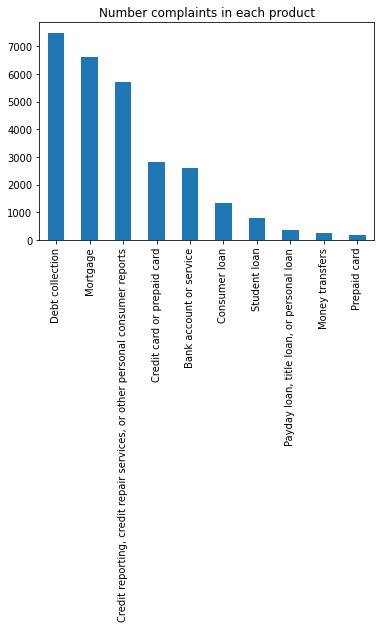

In [8]:
df['Product'].value_counts().sort_values(ascending=False).plot(kind='bar', 
                                                                title='Number complaints in each product')

In [9]:
def print_plot(index):
    example = df[df.index == index][['Issue', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [10]:
print_plot(10)

False statements or representation
Product: Debt collection


In [12]:
print_plot(100)

Communication tactics
Product: Debt collection


## preprocessing the data nad cleansing

In [13]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = str(text).lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Issue'] = df['Issue'].apply(clean_text)

In [14]:
df['Issue'] = df['Issue'].str.replace('\d+', '')

In [15]:
print_plot(10)

false statements representation
Product: Debt collection


In [16]:
print_plot(100)

communication tactics
Product: Debt collection


## transform the text into tokens and sequences

In [19]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Issue'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 161 unique tokens.


In [20]:
X = tokenizer.texts_to_sequences(df['Issue'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (28116, 250)


In [21]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (28116, 10)


## split train and test sets

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(25304, 250) (25304, 10)
(2812, 250) (2812, 10)


## train the model

In [23]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
Total params: 5,081,410
Trainable params: 5,081,410
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
epochs = 3
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
89/89 [==============================] - 191s 2s/step - loss: 1.6579 - accuracy: 0.5356 - val_loss: 0.2284 - val_accuracy: 0.9648
Epoch 2/3
89/89 [==============================] - 165s 2s/step - loss: 0.1404 - accuracy: 0.9741 - val_loss: 0.0532 - val_accuracy: 0.9917
Epoch 3/3
89/89 [==============================] - 165s 2s/step - loss: 0.0449 - accuracy: 0.9914 - val_loss: 0.0310 - val_accuracy: 0.9945


## evaluating the model

In [25]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

88/88 [==============================] - 6s 65ms/step - loss: 0.0322 - accuracy: 0.9940
Test set
  Loss: 0.032
  Accuracy: 0.994


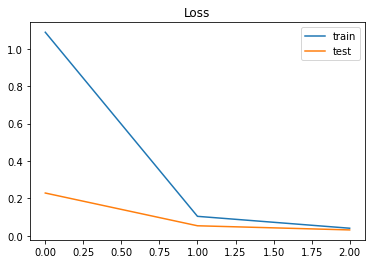

In [26]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

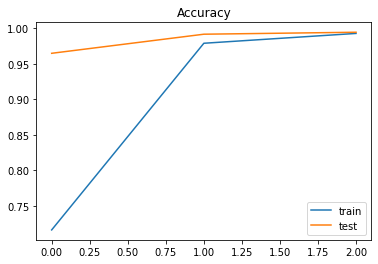

In [29]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Predict with a new complaint issue

In [31]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, "\n" ,labels[np.argmax(pred)])

[[0.01421928 0.02880315 0.04204255 0.56727743 0.00215587 0.02594563
  0.27694565 0.02081667 0.01208621 0.00970762]] 
 Credit card or prepaid card
